In [14]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import sleep
from os import listdir
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation as FA

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

### Loading the data

There are 100 trajectories of engine degradation in EACH of the datasets (train and test). For the train data, each engine is run from a certain normal condition till failure. For the test data, each engine is NOT run until failure (or we have data until a specific point of the engine's state). The amount of time cycles left for this engine to still be 'normal' is what we call RUL, or Remaining Useful Lifetime.

#### Predicting what the RUL is for the last state of each machine in the test set will be our prediction task.

In [15]:
folder_path = '../CMAPSS/'
listdir(folder_path)

['Damage Propagation Modeling.pdf',
 'readme.txt',
 'RUL_FD001.txt',
 'RUL_FD002.txt',
 'RUL_FD003.txt',
 'RUL_FD004.txt',
 'test_FD001.txt',
 'test_FD002.txt',
 'test_FD003.txt',
 'test_FD004.txt',
 'train_FD001.txt',
 'train_FD002.txt',
 'train_FD003.txt',
 'train_FD004.txt',
 'x.txt']

In [16]:
df_train = pd.read_csv(folder_path + 'train_FD001.txt', header = None, sep = ' ')
df_test = pd.read_csv(folder_path + 'test_FD001.txt', header = None, sep = ' ')
rul_test = pd.read_csv(folder_path + 'RUL_FD001.txt', header = None)

for df in [df_train, df_test, rul_test]:
    display(df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


,0
0,112
1,98
2,69
3,82
4,91


Attaching column names: We have three operational setting columns (os + number), and 21 sensor columns (s + number). We have dropped the last two columns containing NaNs.

In [17]:
col_names = []
col_names.append('unit_number')
col_names.append('time_cycle')

for i in range (1, 4):
    col_names.append('setting'+ str(i))
    
for i in range (1, 22):
    col_names.append('sensor' + str(i))
    
print(col_names)

['unit_number', 'time_cycle', 'setting1', 'setting2', 'setting3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21']


In [18]:
# Drop last two columns and make train and test df
df_train = df_train.iloc[:,:-2].copy()
df_train.columns = col_names
display(df_train.head())

df_test = df_test.iloc[:,:-2].copy()
df_test.columns = col_names
display(df_test.head())

,unit_number,time_cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


,unit_number,time_cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


#### Attaching RUL(remaining useful lifetime) values to the datasets

For the train data, the RUL values are not specified, but the document regarding this dataset specifies that for the training data, all the engines were run to failure. Thus, for example, if we had five rows for a specific unit, say unit 7:Then we know that the last row is when the RUL value becomes 0 (failure), so the RUL for this unit would be attached in this way. 

For the test data, we have the 'solutions' for the test engines in a separate file called rul_test (the name that I used for dataframe). I will use that to attach the RUL values for the test as well.

In [19]:
rul_list = []

for n in np.arange(1,101):
    
    time_list = np.array(df_train[df_train['unit_number'] == n]['time_cycle'])
    length = len(time_list)
    rul = list(length - time_list)
    rul_list += rul
    
df_train['rul'] = rul_list

rul_list = []

for n in np.arange(1,101):
    
    time_list = np.array(df_test[df_test['unit_number'] == n]['time_cycle'])
    length = len(time_list)
    rul_val = rul_test.iloc[n-1].item()
    rul = list(length - time_list + rul_val)
    rul_list += rul

df_test['rul'] = rul_list

for df in [df_train, df_test]:
    display(df.head())

,unit_number,time_cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


,unit_number,time_cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


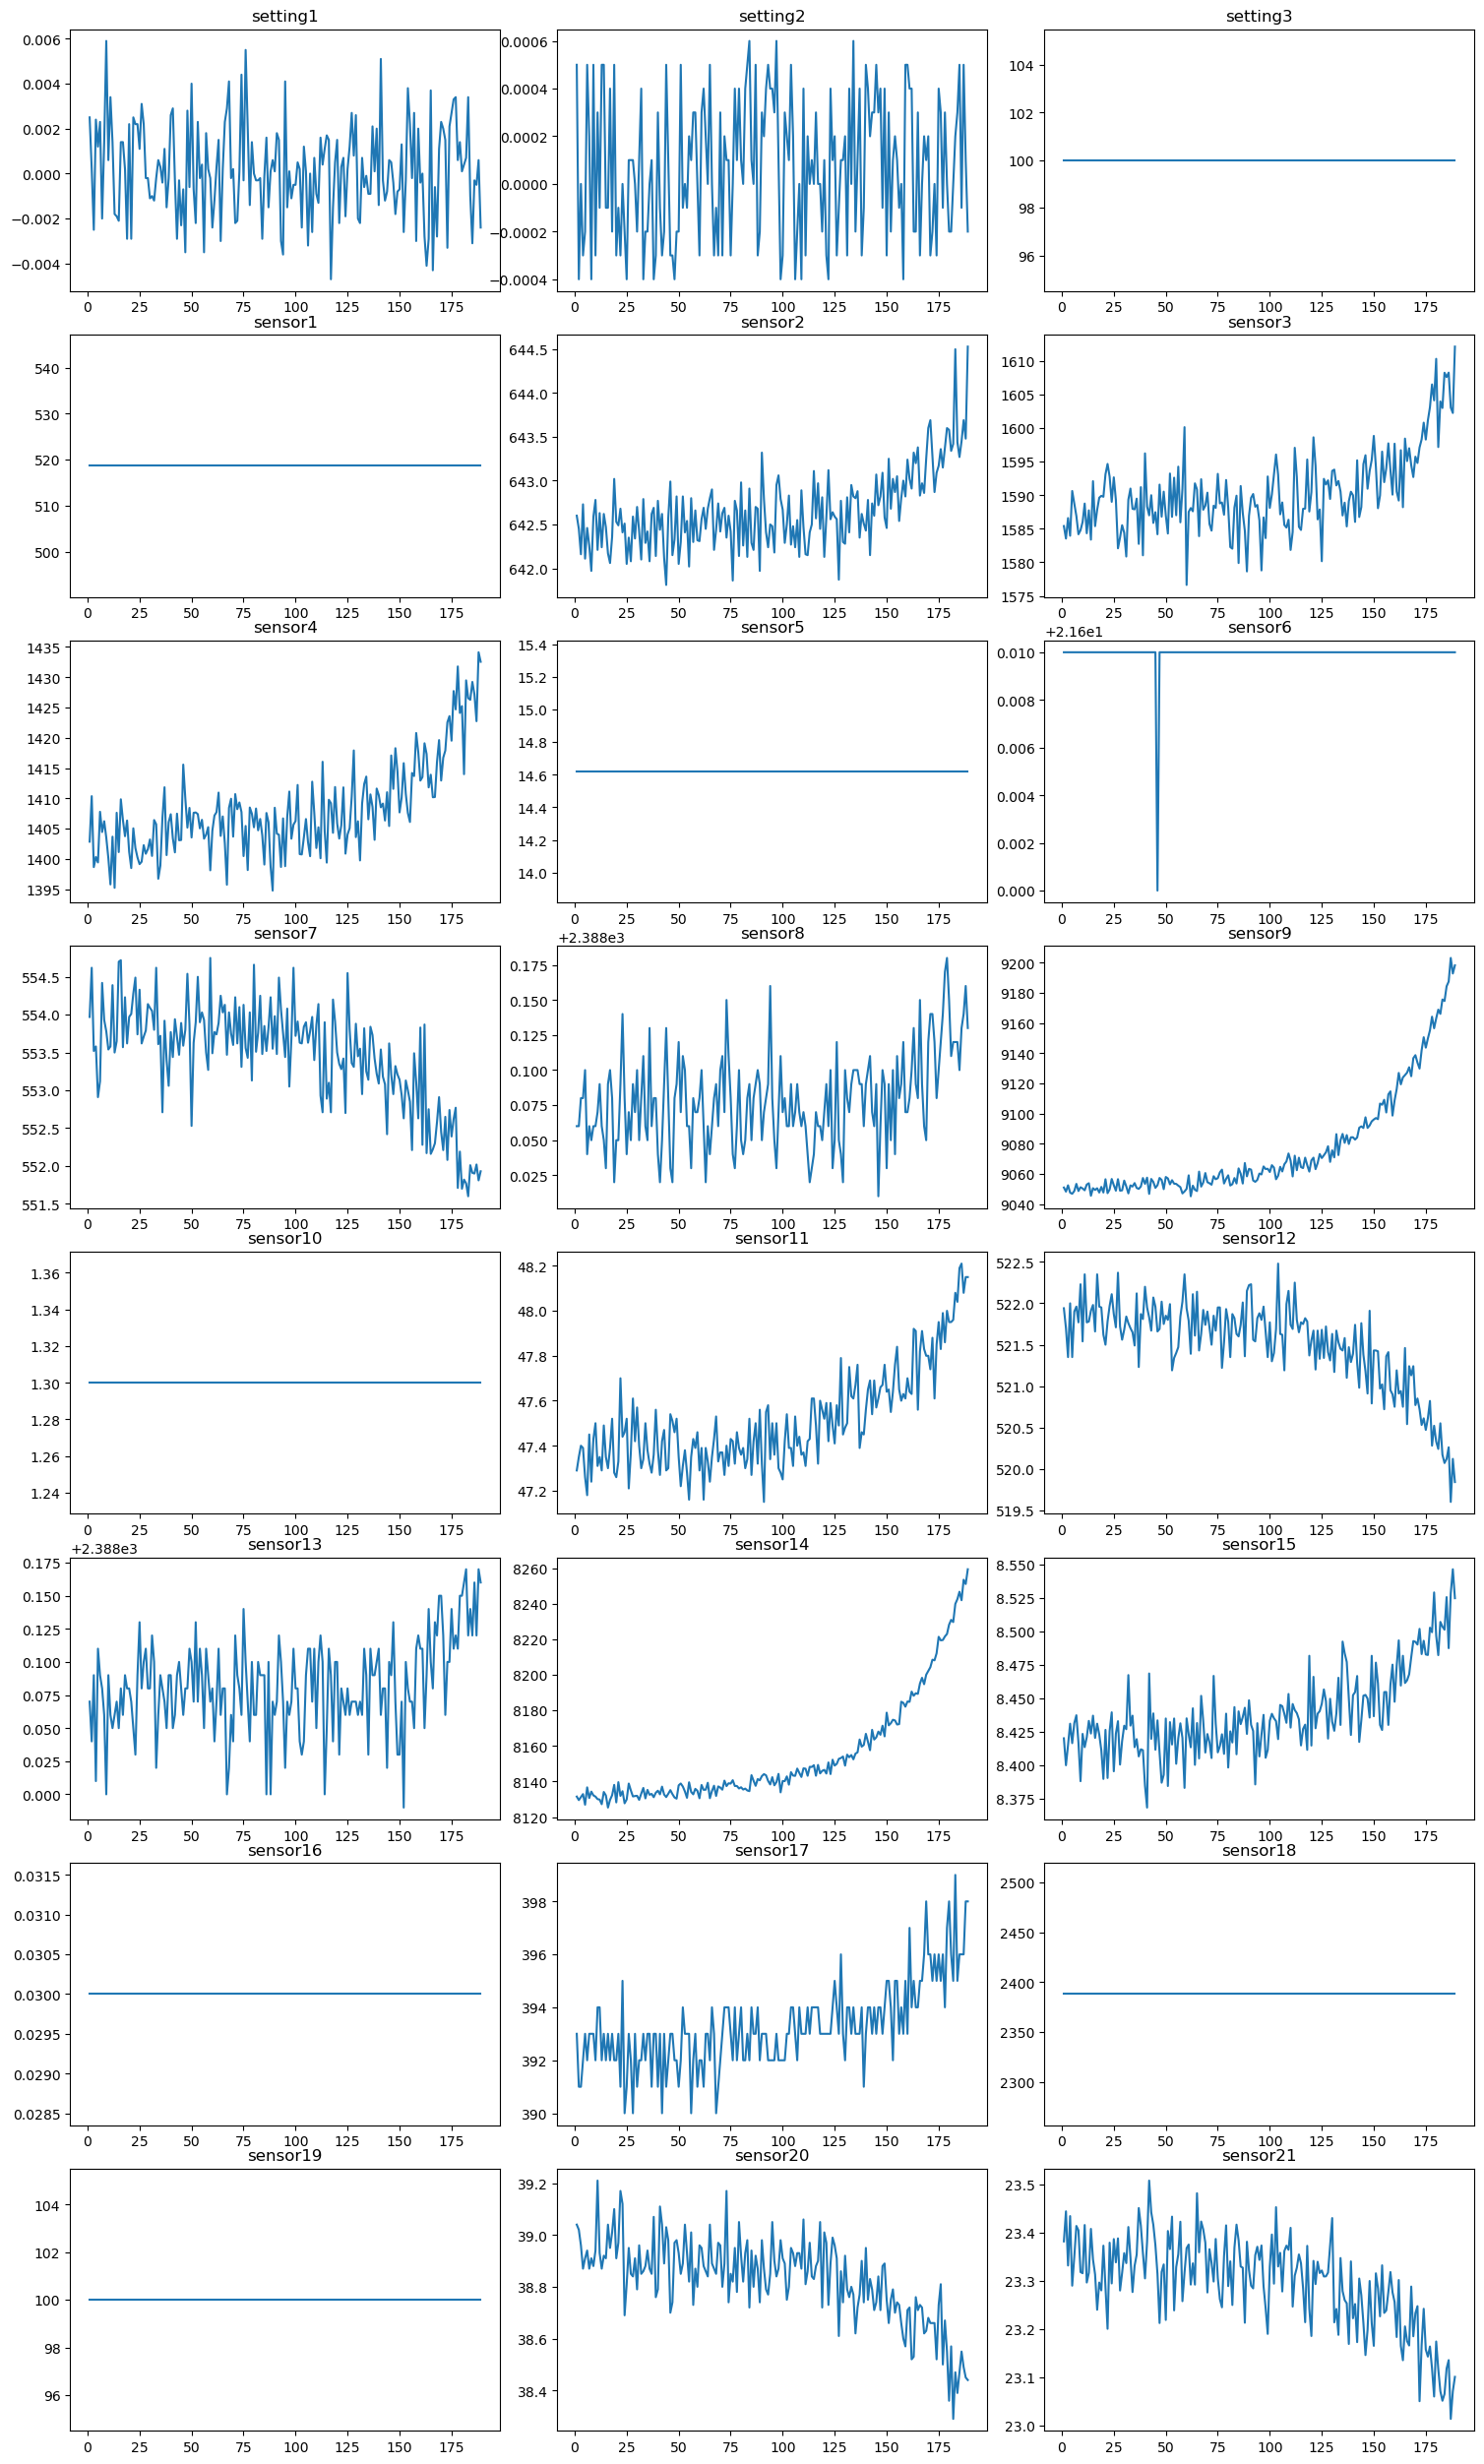

In [25]:
# Let's check all the sensor values of a specific engine train set (unit 4)
sample_unit = 4
sample_unit_df = df_train[df_train['unit_number'] == sample_unit].copy()

fig, axes = plt.subplots(8,3, figsize = (15,25))
fig.tight_layout()

j = -1
for c in df_train.columns:
    
    if 's' in c:
        j += 1
        axes[j // 3, j % 3].plot(sample_unit_df['time_cycle'], sample_unit_df[c])
        axes[j // 3, j % 3].set_title(c)

#### To create high resolution figure of each sensor values

In [23]:
# # Let's check all the sensor values of a specific engine train set (unit 4)
# sample_unit = 4
# sample_unit_df = df_train[df_train['unit_number'] == sample_unit].copy()

# # Define a higher DPI for high-resolution images
# dpi = 300

# # Create a directory to save the images
# import os
# if not os.path.exists('sensor_plots'):
#     os.makedirs('sensor_plots')

# # Create and save high-resolution plots
# j = -1
# for c in df_train.columns:
    
#     if 's' in c:
#         j += 1
#         plt.figure(figsize=(10, 6), dpi=dpi)  # Adjust figsize and DPI for high resolution
#         plt.plot(sample_unit_df['time_cycle'], sample_unit_df[c])
#         plt.title(c)
        
#         # Save the plot as an image with a meaningful name
#         image_filename = f'sensor_plots/{sample_unit}_{c}.png'
#         plt.savefig(image_filename, dpi=dpi, bbox_inches='tight')
#         plt.close()  # Close the plot to release memory

# # Now, high-resolution plots are saved in the 'sensor_plots' directory

We can notice here, that there are multiple sensors which are not changing its value. Perhaps, they are not useful features for prediction. Would they have similar behaviors for other engine units as well? Below show that yes (standard deviation is 0, or practically 0).

In [27]:
df_train[['setting3','sensor1','sensor5','sensor6','sensor10','sensor16','sensor18','sensor19']].describe()

,setting3,sensor1,sensor5,sensor6,sensor10,sensor16,sensor18,sensor19
count,20631.0,2.063100e+04,2.063100e+04,20631.000000,2.063100e+04,2.063100e+04,20631.0,20631.0
mean,100.0,5.186700e+02,1.462000e+01,21.609803,1.300000e+00,3.000000e-02,2388.0,100.0
std,0.0,6.537152e-11,3.394700e-12,0.001389,4.660829e-13,1.556432e-14,0.0,0.0
min,100.0,5.186700e+02,1.462000e+01,21.600000,1.300000e+00,3.000000e-02,2388.0,100.0
25%,100.0,5.186700e+02,1.462000e+01,21.610000,1.300000e+00,3.000000e-02,2388.0,100.0
50%,100.0,5.186700e+02,1.462000e+01,21.610000,1.300000e+00,3.000000e-02,2388.0,100.0
75%,100.0,5.186700e+02,1.462000e+01,21.610000,1.300000e+00,3.000000e-02,2388.0,100.0
max,100.0,5.186700e+02,1.462000e+01,21.610000,1.300000e+00,3.000000e-02,2388.0,100.0


In [28]:
# We will drop these features from the both dataset
drop_cols1 = ['setting3','sensor1','sensor5','sensor6','sensor10','sensor16','sensor18','sensor19']

df_train = df_train.drop(drop_cols1, axis = 1)
df_test = df_test.drop(drop_cols1, axis = 1)

for df in [df_train, df_test]:
    display(df.head())

,unit_number,time_cycle,setting1,setting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


,unit_number,time_cycle,setting1,setting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,rul
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138


#### Min Max Scaling

In [29]:
#Minmax Scaling
minmax_dict = {}

for c in df_train.columns:
    if 's' in c:
        minmax_dict[c+'min'] = df_train[c].min()
        minmax_dict[c+'max']=  df_train[c].max()
        
for c in df_train.columns:
    if 's' in c:
        df_train[c] = (df_train[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])
        
for c in df_test.columns:
    if 's' in c:
        df_test[c] = (df_test[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])
        
for df in [df_train, df_test]:
    display(df.head())

,unit_number,time_cycle,setting1,setting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,rul
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187


,unit_number,time_cycle,setting1,setting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,rul
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142
1,1,2,0.344828,0.250000,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827,141
2,1,3,0.517241,0.583333,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348,140
3,1,4,0.741379,0.500000,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110,139
4,1,5,0.580460,0.500000,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377,138
